In [1]:
#THESE ARE JUST FOR SETUP  ===================================================================


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
#Fetching the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version =1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"],mnist["target"]
X.shape


(70000, 784)

In [4]:
y.shape

(70000,)

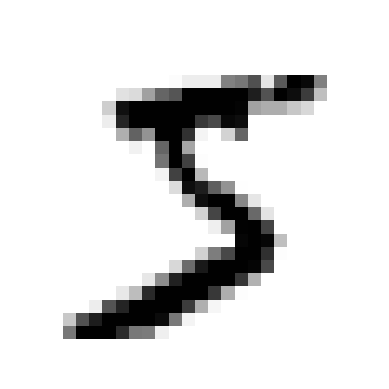

In [5]:
#===========PEEKING TO ONE DIGIT OF THE DATASET========================================================

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]  # let's look at the first digit
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap= "binary")
plt.axis("off")
plt.show()

In [6]:
#===========This is a string, in ml we need to convert it to int========================================
y=y.astype(np.uint8)

In [7]:
#======Creating a test set & SETTING IT ASIDE========================================================

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#----------Creating a binary classifier for the digit 5------------------------------------------------------

y_train_5 = (y_train==5)    # True if the digit is a 5, else False
y_test_5 = (y_test==5)

In [9]:
# USING THE SDG CLASSIFIER (Stochastic Gradient Descent) =========================================================

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [10]:
sgd_clf.predict([some_digit])

c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

Now we will Measure Accuracy using CROSS-VALIDATION

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [13]:
#Measuring accuracy og Base Estimator Class

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#Confusion Matrix

[[9700  300]    ← First row = actually NOT                    
 [ 200  800]]   ← Second row = actually 5

9700 times it correctly said “not 5” → True Negatives           
300 times it wrongly said “5” → False Positives             
200 times it missed the actual 5 → False Negatives           
800 times it correctly said “5” → True Positives             


Precision = TP/ [TP+FP]                 
Recall = TP/ [TP+FN]

Precision: jitne bhi 5 detect hua he , unmese kitne actually 5 hain                
Recall: Total 5's mese kitne detect hua he


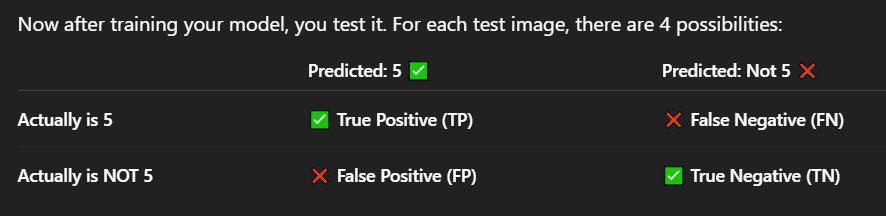

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#   WHY USE THE TRAIN TO PREDICT?
#   Because we are still measuring how well the model will generalize to during training

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
##Why y_train_pred? Because it contains the predicted labels for training set which is generated
# using cross validation

In [18]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [19]:
#=======Precision and Recall========================================================
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 score = precision + recall


In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343847

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores> threshold)
y_some_digit_pred

array([ True])

In [24]:
#Raising the threshold to 8000
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [25]:
#####TO DECIDE WHICH THRESHOLD TO USE, we will use cross_val_predict() by skpecifying the retrun of decision_function
#instead of predictions

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [26]:
## using the precision recall graph versus the decision threshold 
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

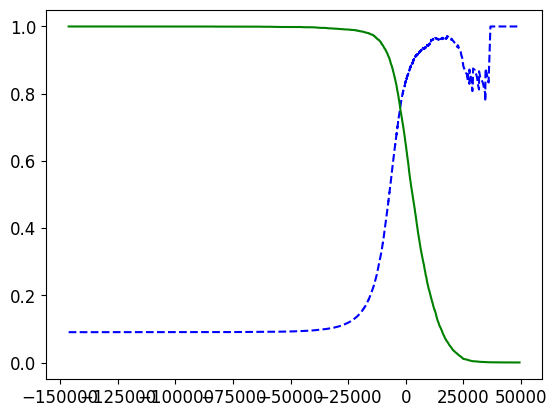

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1],"g-", label="Recall")
    [...]
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [29]:
y_train_pred_90 = (y_scores>=threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

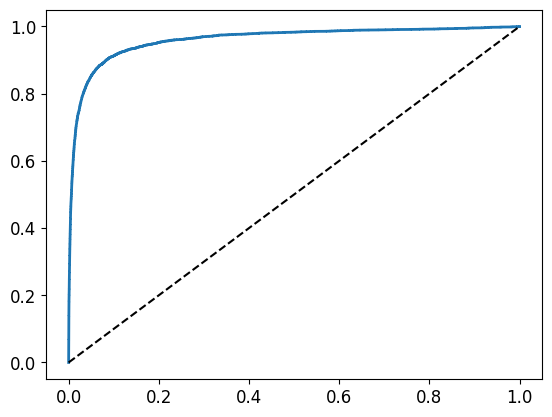

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2,label= label)
    plt.plot([0,1],[0,1],'k--') #Dashed diagonal
    [...]

plot_roc_curve(fpr, tpr)


In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9604938554008616

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

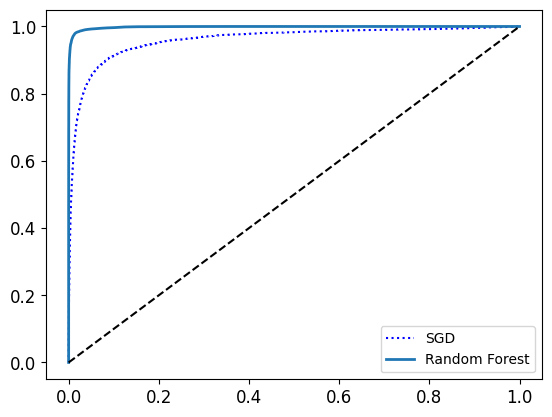

In [37]:
plt.plot(fpr, tpr, "b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

WE will use the One-versus-the-Rest Classifier
In this way we will extend the binary classifier to chaange into multiclass classifier

In [39]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)


np.int64(5)

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

np.uint8(5)

In [44]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature na

array([5], dtype=uint8)

In [45]:
ovr_clf.predict([some_digit])

c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature na

array([5], dtype=uint8)

In [46]:
len(ovr_clf.estimators_)

10

In [47]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [48]:
sgd_clf.decision_function([some_digit])

c:\Users\varad\OneDrive\Documents\Aurelian Geron\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

🎯 Why three arguments?
X_train and y_train are needed so cross_val_score knows what to split.

sgd_clf is needed so it knows what model to train on each fold.

So you need all three:

What to train? → sgd_clf

On what data? → X_train

What are the labels? → y_train

In [50]:
##To improve accuracy we will Scale the data 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

BEFORE WE CALCULATED THE conf_matrix for the binary class 
NOW, after using the OneVsRest Classifier to convert to multiclass classifier 
we are using the conf_materix to analyse the errors


In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

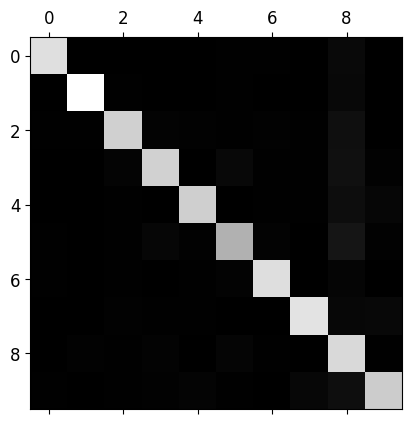

In [52]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

shows a grayscale image where:           
Rows = actual digits (0–9)               
Columns = predicted digits (0–9)             
Each square = number of times a digit was predicted a certain way             
Brighter = more images, darker = fewer images

In [53]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/ row_sums

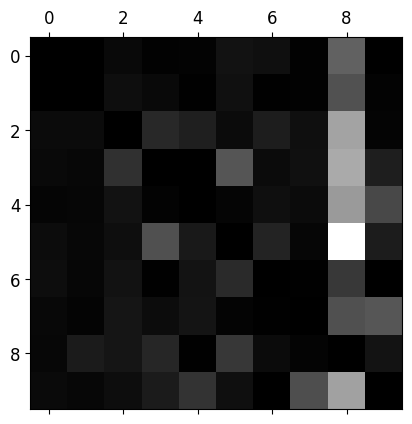

In [54]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

#Here in the conf_matrix "predicting 8 (column)" is full of errors THAN  "actual 8(row)"

In [55]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


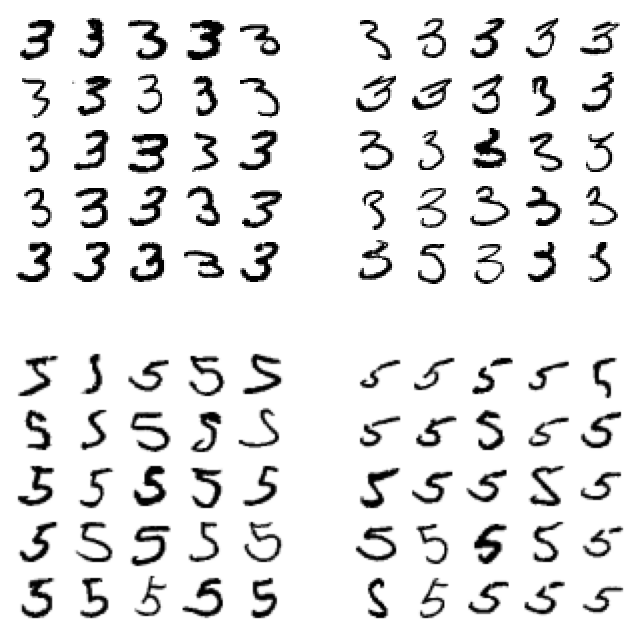

In [56]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size)).swapaxes(1, 2).reshape((size * n_rows, size * images_per_row))
    plt.imshow(image_grid, cmap=mpl.cm.binary, **options)
    plt.axis("off")






plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

*MULTILABEL CLASSIFICATION*

yani ki lets say, in a photo the classifier shd be able to find all the numbers that are present in the photo

In [57]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [59]:
knn_clf.predict([some_digits])


NameError: name 'some_digits' is not defined

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")